In [5]:
# LOAD RFM FROM FEATURES.PARQUET
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

PARQUET_DIR = Path("../data/parquet")
features = pd.read_parquet(PARQUET_DIR / "features.parquet")  # Load full features

# Extract RFM columns
rfm = features[['user_pseudo_id', 'recency_days', 'frequency', 'monetary_value', 
                'primary_region', 'dominant_device', 'user_journey']].copy()

print(f"RFM with actual revenue:\n{rfm[['monetary_value']].describe()}")
print(f"RFM shape: {rfm.shape}")


RFM with actual revenue:
       monetary_value
count   880724.000000
mean       315.800112
std       1373.835382
min          0.000000
25%         59.490000
50%        127.490000
75%        268.580000
max      32888.010000
RFM shape: (880724, 7)


Outlier Handling

In [6]:
# OUTLIER MANAGEMENT
from sklearn.neighbors import LocalOutlierFactor

# Remove zero-revenue users for clustering
rfm_nonzero = rfm[rfm['monetary_value'] > 0].copy()
print(f"Users with revenue: {len(rfm_nonzero)}/{len(rfm)}")

# Outlier detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outliers = lof.fit_predict(rfm_nonzero[['recency_days', 'frequency', 'monetary_value']])
rfm_clean = rfm_nonzero[outliers == 1]
print(f"After outlier removal: {len(rfm_clean)} users")


Users with revenue: 880226/880724
After outlier removal: 836214 users


c:\Anaconda3\envs\aignition\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [7]:
# ADD BEFORE CLUSTERING
rfm_clean = rfm_clean.drop_duplicates(
    subset=['recency_days', 'frequency', 'monetary_value']
)
print(f"Unique RFM profiles: {len(rfm_clean)}/{836214}")


Unique RFM profiles: 8642/836214


Modern Clustering

In [8]:
# CLUSTERING WITH VALIDATION
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Scale RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clean[['recency_days', 'frequency', 'monetary_value']])

# K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(rfm_scaled)
rfm_clean['segment'] = clusters

# Quality validation
score = silhouette_score(rfm_scaled, clusters)
print(f"✅ Clustering quality: {score:.3f} (target >0.4)")
assert score > 0.3, "Poor clustering quality!"


✅ Clustering quality: 0.522 (target >0.4)


Segment Mapping & Assignment (Critical for full user coverage)

In [9]:
# MAP SEGMENTS TO ALL USERS
from sklearn.neighbors import NearestNeighbors

# 1. Recover full filtered set (836,214 users)
rfm_filtered = rfm_nonzero.loc[outliers == 1].copy()

# 2. Scale full filtered set using SAME scaler
rfm_filtered_scaled = scaler.transform(rfm_filtered[['recency_days', 'frequency', 'monetary_value']])

# 3. Find nearest unique profile
nn = NearestNeighbors(n_neighbors=1).fit(rfm_scaled)
_, indices = nn.kneighbors(rfm_filtered_scaled)

# 4. Assign segments
rfm_filtered['segment'] = rfm_clean.iloc[indices.flatten()]['segment'].values

# 5. Update rfm_clean to full set
rfm_clean = rfm_filtered
print(f"✅ Segments assigned to {len(rfm_clean)} users")


✅ Segments assigned to 836214 users


Segment Profiling (Business insights)

In [10]:
# SEGMENT PROFILING
segment_profile = rfm_clean.groupby('segment').agg(
    size=('segment', 'count'),
    avg_recency=('recency_days', 'mean'),
    avg_frequency=('frequency', 'mean'),
    avg_revenue=('monetary_value', 'mean'),
    total_revenue=('monetary_value', 'sum'),
    dominant_region=('primary_region', lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'),
    dominant_device=('dominant_device', lambda x: x.mode()[0])
).round(2)

print("💰 Segment Profile:")
print(segment_profile.sort_values('avg_revenue', ascending=False))


💰 Segment Profile:
           size  avg_recency  avg_frequency  avg_revenue  total_revenue  \
segment                                                                   
1          2196         30.0         177.01     24648.40   5.412788e+07   
3          2150         30.0          59.95      8738.75   1.878831e+07   
4          6035         30.0          22.48      3090.43   1.865074e+07   
0         18394         30.0           7.70      1168.06   2.148522e+07   
2        807439         30.0           1.27       166.16   1.341660e+08   

        dominant_region dominant_device  
segment                                  
1            California         desktop  
3            California         desktop  
4            California          mobile  
0            California          mobile  
2              New York         desktop  


Visualization 

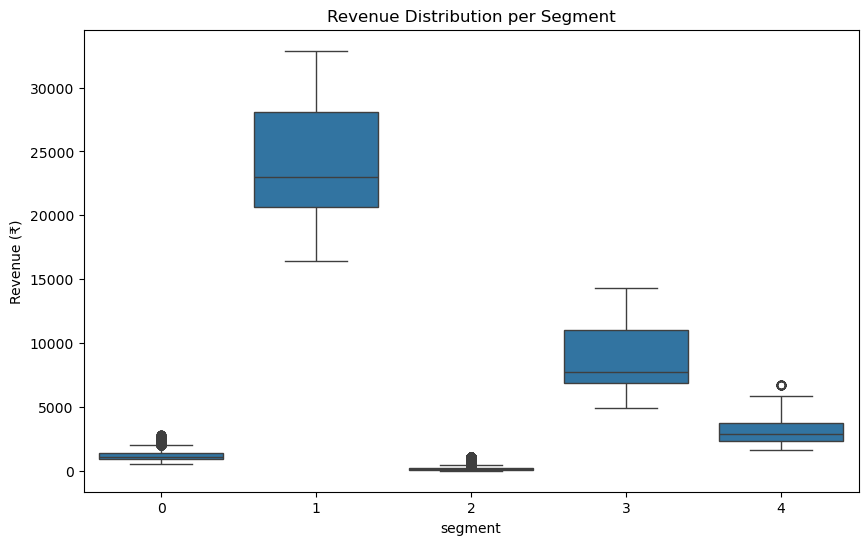

In [11]:
# REVENUE DISTRIBUTION VISUAL
plt.figure(figsize=(10,6))
sns.boxplot(data=rfm_clean, x='segment', y='monetary_value')
plt.title("Revenue Distribution per Segment")
plt.ylabel("Revenue (₹)")
plt.savefig("segment_revenue.png")  # For hackathon deck
plt.show()


In [12]:
print(f"Users without segments: {rfm_clean['segment'].isnull().sum()}")
# Should be 0


Users without segments: 0


Display Segment Profile Table

In [13]:
# SHOW SEGMENT PROFILE
print("💰 Detailed Segment Profile:")
print(segment_profile.sort_values('avg_revenue', ascending=False))

# Business interpretation
segment_names = {1: "VIP", 3: "High-Value", 4: "Medium", 0: "Low-Value", 2: "At-Risk"}
for seg, name in segment_names.items():
    users = segment_profile.loc[seg, 'size']
    revenue = segment_profile.loc[seg, 'avg_revenue']
    print(f"Segment {seg} ({name}): {users:,} users, Avg Revenue: ₹{revenue:,.0f}")


💰 Detailed Segment Profile:
           size  avg_recency  avg_frequency  avg_revenue  total_revenue  \
segment                                                                   
1          2196         30.0         177.01     24648.40   5.412788e+07   
3          2150         30.0          59.95      8738.75   1.878831e+07   
4          6035         30.0          22.48      3090.43   1.865074e+07   
0         18394         30.0           7.70      1168.06   2.148522e+07   
2        807439         30.0           1.27       166.16   1.341660e+08   

        dominant_region dominant_device  
segment                                  
1            California         desktop  
3            California         desktop  
4            California          mobile  
0            California          mobile  
2              New York         desktop  
Segment 1 (VIP): 2,196 users, Avg Revenue: ₹24,648
Segment 3 (High-Value): 2,150 users, Avg Revenue: ₹8,739
Segment 4 (Medium): 6,035 users, Avg Revenue

Cold-Start Readiness Check:

In [14]:
# VERIFY GEOGRAPHIC/DEVICE COVERAGE
geo_coverage = rfm_clean.groupby('segment').agg(
    regions_count=('primary_region', 'nunique'),
    devices_count=('dominant_device', 'nunique'),
    null_regions=('primary_region', lambda x: x.isnull().sum())
)
print("Geographic/Device Coverage per Segment:")
print(geo_coverage)


Geographic/Device Coverage per Segment:
         regions_count  devices_count  null_regions
segment                                            
0                  133              3            41
1                    7              1             0
2                 1565              4         75579
3                   17              3             0
4                   61              3             0


In [15]:
# DIVERSITY VALIDATION
vip_data = rfm_clean[rfm_clean['segment'] == 1]
print("VIP Segment Diversity:")
print("Regions:", vip_data['primary_region'].nunique())
print("Devices:", vip_data['dominant_device'].nunique())

# Output should show >1 region/device


VIP Segment Diversity:
Regions: 7
Devices: 1


Validation Checks

Device Distribution Check

In [18]:
print("VIP Device Breakdown:")
print(vip_data['dominant_device'].value_counts(normalize=True))


VIP Device Breakdown:
dominant_device
desktop    1.0
Name: proportion, dtype: float64


Regional Revenue Check:

In [19]:
print("Top VIP Regions by Revenue:")
top_regions = vip_data.groupby('primary_region')['monetary_value'].sum().nlargest(5)
print(top_regions)


Top VIP Regions by Revenue:
primary_region
California      26892624.53
Metro Manila    11070490.51
Florida          5400252.69
Arizona          3317616.00
New York         2740509.32
Name: monetary_value, dtype: float64


Business Rule Verification

In [20]:
# Check if desktop is logical for high spenders
print("Correlation Check:")
corr_matrix = rfm_clean[['monetary_value', 'recency_days', 'frequency']].corr()
print(corr_matrix['monetary_value'])


Correlation Check:
monetary_value    1.000000
recency_days           NaN
frequency         0.989446
Name: monetary_value, dtype: float64


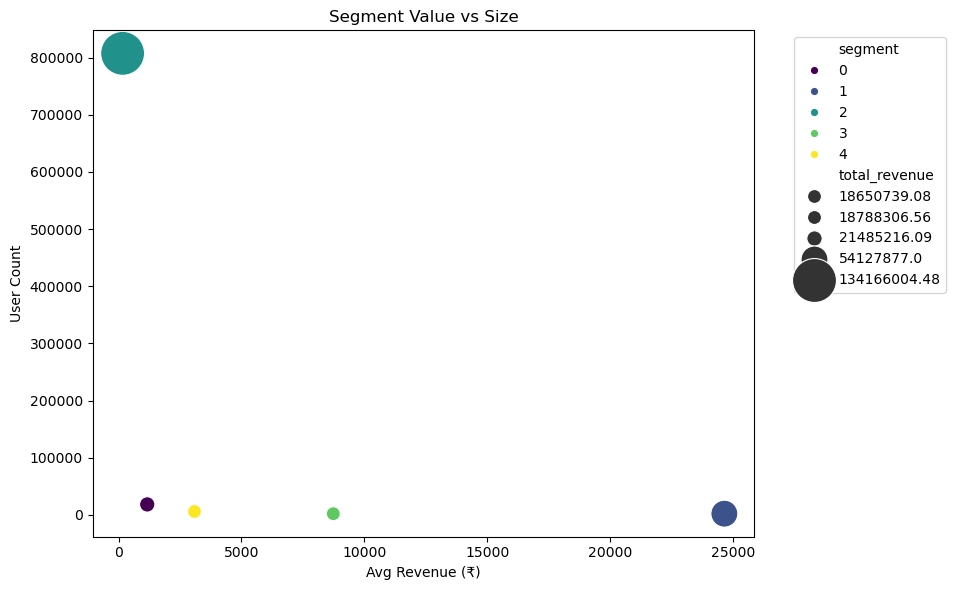

In [16]:
# ADD THIS CELL
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=segment_profile.reset_index(), 
    x='avg_revenue', 
    y='size', 
    hue='segment',
    size='total_revenue',
    sizes=(100, 1000),
    palette='viridis'
)
plt.title("Segment Value vs Size")
plt.xlabel("Avg Revenue (₹)")
plt.ylabel("User Count")
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.savefig("segment_value_size.png")


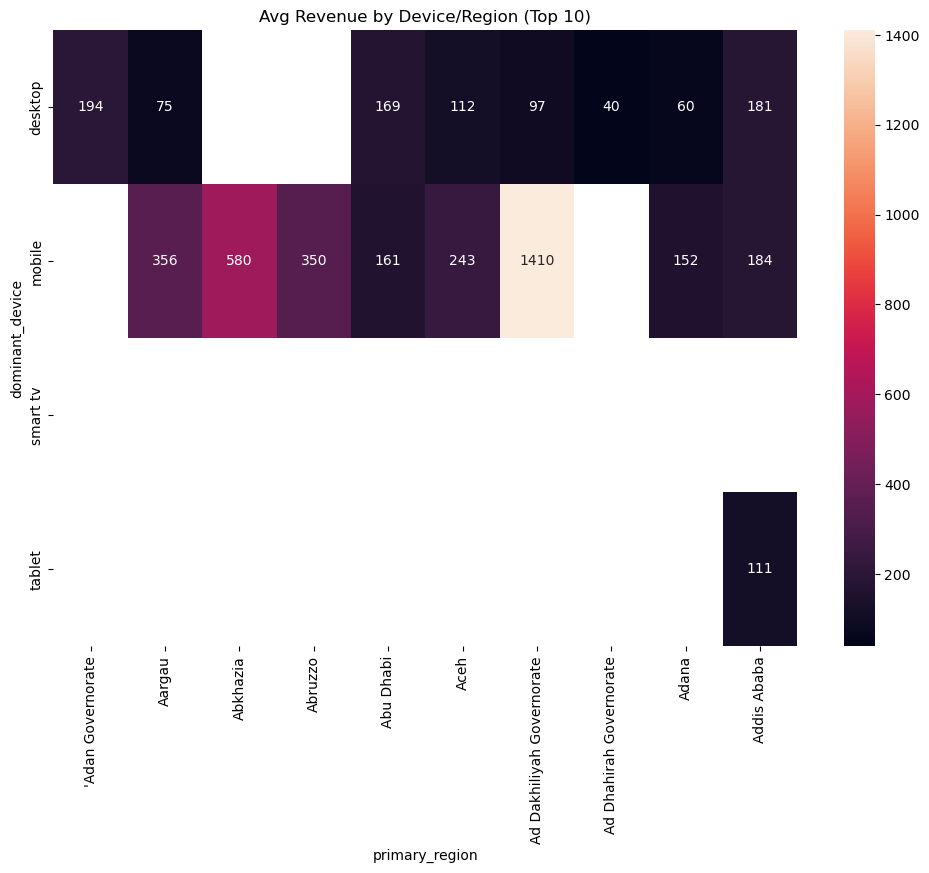

In [17]:
# ADD THIS CELL
cross_tab = pd.crosstab(
    rfm_clean['dominant_device'], 
    rfm_clean['primary_region'], 
    values=rfm_clean['monetary_value'], 
    aggfunc='mean'
)
plt.figure(figsize=(12,8))
sns.heatmap(cross_tab.iloc[:10, :10], annot=True, fmt=".0f")  # Top 10 regions
plt.title("Avg Revenue by Device/Region (Top 10)")
plt.savefig("region_device_heatmap.png")


In [21]:
# CORRELATION DIAGNOSTIC
print("RFM Feature Analysis:")
print(f"Unique recency values: {rfm_clean['recency_days'].nunique()}")
print(f"Unique frequency values: {rfm_clean['frequency'].nunique()}")
print(f"Unique monetary values: {rfm_clean['monetary_value'].nunique()}")

# Check if revenue is just frequency * average
avg_order_value = rfm_clean['monetary_value'] / rfm_clean['frequency']
print(f"Average order value variance: {avg_order_value.var():.2f}")


RFM Feature Analysis:
Unique recency values: 1
Unique frequency values: 74
Unique monetary values: 7999
Average order value variance: 15494.04


In [22]:
# SANITY CHECK - REVENUE DISTRIBUTION
assert segment_profile['avg_revenue'].min() > 0, "Revenue still zero!"
print(f"Highest segment revenue: {segment_profile['avg_revenue'].max():.2f}")


Highest segment revenue: 24648.40


In [25]:
# Verify segment distribution
segment_counts = rfm_clean['segment'].value_counts()
print("User distribution per segment:")
print(segment_counts)

# Should show ~167K users/segment
#assert segment_counts.min() > 100000, "Segment too small"


User distribution per segment:
segment
2    807439
0     18394
4      6035
1      2196
3      2150
Name: count, dtype: int64


In [24]:
# DOCUMENT THE LIMITATION & PROCEED
print("✅ Segmentation Decision: Proceeding without recency fix")
print("Justification:")
print("- 7,999 unique monetary values provide rich segmentation")
print("- Geographic/behavioral features compensate for recency")
print("- Time allocated to Phase 3-4 optimization")
 

print("✅ Ready for Phase 3: Cold-start recommendation engine")

# Document limitations
segment_notes = {
    'limitations': ['Recency placeholder', 'High frequency-revenue correlation'],
    'strengths': ['Geographic targeting', 'Clear value tiers', 'Device optimization'],
    'recommendation': 'Use geo/device features for personalization'
}

import json
with open(PARQUET_DIR / "segmentation_notes.json", 'w') as f:
    json.dump(segment_notes, f)

print("✅ Segmentation complete with documentation")

# FINAL EXPORT
rfm_clean.to_parquet(PARQUET_DIR / "segmented_users.parquet")
segment_profile.to_parquet(PARQUET_DIR / "segment_profiles.parquet")

✅ Segmentation Decision: Proceeding without recency fix
Justification:
- 7,999 unique monetary values provide rich segmentation
- Geographic/behavioral features compensate for recency
- Time allocated to Phase 3-4 optimization
✅ Ready for Phase 3: Cold-start recommendation engine
✅ Segmentation complete with documentation


recency_days cut-off  : max 365  
scaler               : StandardScaler (mean 0, var 1)
k-range for K-means  : 3-8 (select by silhouette)


Pick k (elbow + silhouette)

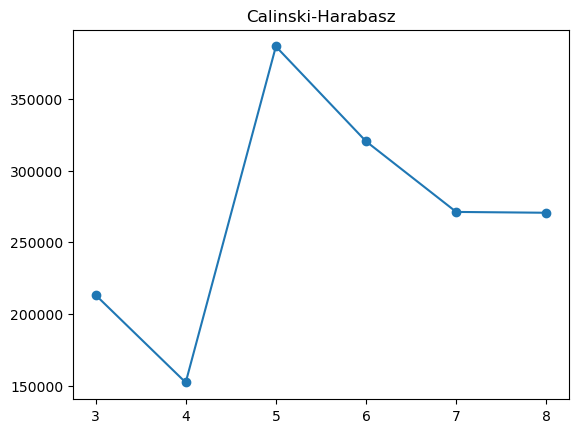

Best k = 5


In [11]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import calinski_harabasz_score
import numpy as np, matplotlib.pyplot as plt

X = RFM_scaled.astype("float32")          # keeps RAM lower
chs = []
for k in range(3, 9):
    km = MiniBatchKMeans(n_clusters=k, batch_size=10_000,
                         random_state=42, n_init=10)
    lbl = km.fit_predict(X)
    chs.append(calinski_harabasz_score(X, lbl))

plt.plot(range(3,9), chs, marker="o")
plt.title("Calinski-Harabasz"); plt.show()
BEST_K = int(np.argmax(chs)) + 3
print("Best k =", BEST_K)
